# 1 Project description and previous work
This project is inspired by the work done in [Collaborative foraging using beacons](http://cs.gmu.edu/~sean/papers/aamas10-beacons.pdf). This paper introduces an algorithm to extend the work previously done for ant foraging in a discrete environment to a continuous one using beacons to store pheromone's values.
The environment is a continuous bounded 2D region of space which contains a nest, a food source and some obstacles. The agents in this model are ants and their main goal is to create the shortest path between their nest and the food source. They do so by laying and following pheromone trails whose values are stored inside beacons. Those beacons can be deployed, moved, and removed by ants and can be sensed by them up to a fixed maximum distance referred as range. The desired collective behaviour is the emergence of an optimized path between food source and nest represented by a set of beacons with overlapping ranges (referred inside this report as beacons's network, as ants move between beacons within range, so "being closer than range" can be used as a rule to determine which beacons are connected) which guides ants's movement.Details on beacons management, pheromones update, and other model's parameters are reported inside the original article.


In this project two main variations are explored:


1) A new set of probabilities for the deployment and removal of beacons is discussed. This novelty challenges the previous assumption that a ceiling on the number of deployable beacons  is an effective way to generate a sparse beacons's network  and addresses few pitfalls of the algorithm emerged during the simulations.


2) A finite beacon's lifetime is introduced and the robustness of the algorithm is discussed. Such a novelty reflects a more realistic model where beacons have a finite powersource.
 
# 2 Model's details, behaviour and implementation

## 2.1 Model's details
The environment simulated is an obstacle free, bounded, continuous field whose size is 100x100 arbitrary length units. Inside this field there’s a fixed nest located at (10, 10) from the top left corner and a fixed source of food located at (90, 90). The starting position of the ants is the nest location. At each timestep every ant takes its stochastic action based on the state of the beacons that are inside its range (which is set to be the same of the beacon's one).To enforce that all ants actions happen before beacons ones (they let the pheromones evaporate and, if required, they shrink their range and deactivate themselves when the end of their lifetime is reached) inside the same timestep, the latter has been divided in  a whole timestep x  reserved for ants and a subsequent half timestep x.5 reserved for beacons.

Agents can move, remove, and deploy beacons, follow the pheromones, move randomly inside the beacons's network and move randomly within their range if they are outside the range of any beacon. How an agent picks an action is determined by a set of constant probabilities conditioned by a set of requirements. For example, moving a beacon happens with probability pMove when the requirements coded inside the function canMove are met.


## 2.2 Behaviour of the model
As a general guide of what happens inside a typical simulation, few phases can be identified.

1) Searching phase: in the first part of the simulation ants cover the environment with an irregular grid of beacons until the system runs out of deployable beacons or food is found. This exploration is allowed by the fact that the pheromone used to reach the food (foragingPheromone) has a value of 0 for every beacon and, if this phase is short enough, the requirements set inside  the function canRemove aren't met.


2) Reinforcing the best path: once food is found, ants start to get back to the nest, creating a sub-optimal path that will be optimized by straightening beacon’s position through move actions or taking paths that have less beacons inside them.


3) Through the removal or movement of the beacons eventually the network will be divided into disconnected parts. If the isolated beacons don’t have any ant inside they are left on their own. If ants are trapped inside this disconnected network of beacons they can either collapse the network on the local maximum or reconnect to the rest of the beacons, generating a new sub-optimal path between the food source and the nest.

## 2.3 Implementation

The implementation is in java, developed using [MASON](https://cs.gmu.edu/%7Eeclab/projects/mason/#Download) libraries.

MASON provides a class SimState as acore engine to develop simulations. Inside that there’s a scheduler to handle agents’s actions and a random number generator to handle the stochastic side of the model. The class ForagingWithBeacons extends this class including all the Continuous2D fields needed to locate agents, beacons, nest, and food source. Every element inside the model is a class which implements the Steppable interface required by the scheduler’s methods. An ausiliary agent called statAgent is used to gather and print out the relevant statistics about the simulation.

A graphical interface is then developed through various portrayals located inside MASON's visualization libraries to see in real time the model’s behaviour and to change on the fly few key parameters of the model.
The graphical representation of every component of the model is as it follows:

- Beacons are hexagons with a circle around them with the size of their range. The hexagon’s color reflects the value of foraging pheromone while the outer circle’s color reflects the value of ferrying pheromone. If the value of pheromones is 0 the hexagon or the outer circle is red as a visual cue to mark the fact that either the beacon is separated from the rest of the network or the propagation of foraging pheromone hasn’t started yet ( as no food has been found yet).


- Ants are dots and their color reflects their status: they are yellow if they don’t carry food or red if they do.


- Nests are represented as magenta ovals.


- Food sources are cyan ovals.


# 3 Beyond a fixed upper limit on deployable beacons

## 3.1 Open issues in the article's model

In the original article new beacons are deployed with a constant probability pDeploy = 0.9 until maxBeaconNumber is reached. Once the number of beacons matches this threshold, no more beacons can be deployed. This poses two problems: if maxBeaconNumber is too low, the initial exploration can’t cover enough surface of the environment to reach the food. Secondly, if the beacons’s network is broken into disconnected pieces and maxBeaconNumber is reached with no accessible beacon that can be removed, the algorithm grinds to a halt.


To ease this limitations a new pDeploy is proposed. It takes the functional form of $ pDeploy(beaconsNumber) = \exp(-\frac{ beaconsNumber}{maxBeaconNumber})$ . Such function allows the beacon’s number to get over the threshold if it’s set too low and allows the creation of new beacons at any time at a cost of an increasingly small probability of deployment.


Here is visualized the behaviour of the original model, which will be referred as "const" inside the data analysis.


![constNotEnoughBeacons](img/notEnoughBeacons.gif)

The last frame captured shows a configuration of unconnected islands of beacons with ants stucked inside. The pheromone levels are distributed in such a way that there aren’t removable beacons and maxBeaconNumber is reached.


Here is visualized the behaviour of the new proposed version of the algorithm, referred as "exp" inside the data analysis.

![expNotEnoughBeacons](img/notEnoughBeaconsExp.gif)




Then a second variation is introduced to solve the problem of getting stuck in local maxima. This issue arises once a region of the beacons’s network is separated from the rest of the connected part. Such region collapses on its local maximum and every new beacon deployed will be subsequently removed as it is seen by the algorithm as obsolete (as it matches the requirements of canRemove). The only way to get out of this situation is to hope that the network gets reconnected by ants which aren’t trapped inside the maximum. The proposed solution works by taking into account a locality estimator called localityCount. It’s defined as the time spent without changing the beacon chosen as best candidate inside canRemove. The current beacon (referred as currBeacon inside the code), with probability $ pRemove( localityCount ) = 1 - ( 1 - \frac {localityCount} { \tau})^{0.2} $, is removed even if it doesn’t meet the requirements set by the original algorithm inside the function canRemove. $\tau$ is set to 80. This allows the removal of local maxima. If such maximum is the only beacon in its neighborhood, a new exploration will start with beacons with 0 as pheromones values which can’t be removed until they reconnect with the rest of the network. This variation of the algorithm will be referred as "expAndRem" inside the data analysis.

The image below shows a simulation with 10 ants and a maxBeaconNumber = 30. This extreme condition is used to clearly show the impact of this variation of the algorithm. This is the behaviour that emerges from the “exp” variation (as the algorithm with constant pDeploy won’t be able to reach the food).
![stuck exp](img/stuckExp.gif)


Here is a run of the exact same simulation with the "expAndRem" variation. The frames refer to the same time inside the simulation.
![stuck rem](img/stuckExpAndRem.gif)


As the ants gets stuck inside local maxima, the dominant beacon is deleted. Signs of this behaviour are the red parts of the beacon’s network, where the ants remained without a beacon and started a new exploration (similarly to the exploration carried out at the beginning, but in this case also the ferrying pheromone is set to 0).

## 3.2 Simulations results 

The StatAgent included in the implementation outputs the performances of the model every 100 timesteps.This data is collected for multiple runs of every version of the algorithm of every value of maxBeaconNumber and is analyzed in the code that follows.

In [1]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

diffMaxBeacons = pd.read_csv('data/diffMaxBeacons.csv.bz2')
#the unused parameter beaconTimescale was set at different constant values to distinguish the 3 variations, 
#here it is swapped with a proper label
types = {15000000:'exp', 150:'const',100:'expAndRem'}
diffMaxBeacons['type'] = diffMaxBeacons['beaconTimescale'].map(lambda x : types[x])
diffMaxBeacons.drop(columns='beaconTimescale',inplace=True)

diffMaxBeacons.head()

,maxBeaconNumber,time,foodIncomingRate,foodRecovered,beaconsNumber,pathLength,foundFood,foundHome,beaconRem,exploration,startExploration,beaconMov,followPh,beaconDep,wanderPh,randomMove,foodPerAnt,sqFoodPerAnt,seed,type
0,70,0.0,0.0,0,8,0.0,0.0,0.0,0.0000,0.0000,0.0010,0.0,0.0,0.0008,0.0081,0.0001,0.0,0.0,-288400744,const
1,70,100.0,0.0,0,70,0.0,0.0,0.0,0.0054,0.3384,0.0687,0.0,0.0,0.0116,0.5759,0.0000,0.0,0.0,-288400744,const
2,70,200.0,0.0,0,70,0.0,0.0,0.0,0.0065,0.3019,0.0639,0.0,0.0,0.0065,0.6212,0.0000,0.0,0.0,-288400744,const
3,70,300.0,0.0,0,70,0.0,0.0,0.0,0.0033,0.3100,0.0686,0.0,0.0,0.0033,0.6148,0.0000,0.0,0.0,-288400744,const
4,70,400.0,0.0,0,70,0.0,0.0,0.0,0.0008,0.3069,0.0676,0.0,0.0,0.0008,0.6239,0.0000,0.0,0.0,-288400744,const


In [2]:
# This code displays the number of simulations for each type of simulation included in the data analysis.
# The seed column stands for the count of different seeds, hence the number of simulations.
# More simulations were required to reduce the variance with low maxBeaconNUmber values.
diffMaxBeacons.loc[:,['type','seed','maxBeaconNumber']].drop_duplicates().groupby(['type','maxBeaconNumber']).count()

seed
type      maxBeaconNumber      
const     30                 12
          50                 12
          70                 12
          100                24
          200                12
          500                12
          1000               12
exp       30                 24
          50                 24
          70                 24
          100                24
          200                12
          500                12
          1000               12
expAndRem 30                 24
          50                 24
          70                 24
          100                24
          200                12
          500                12
          1000               12

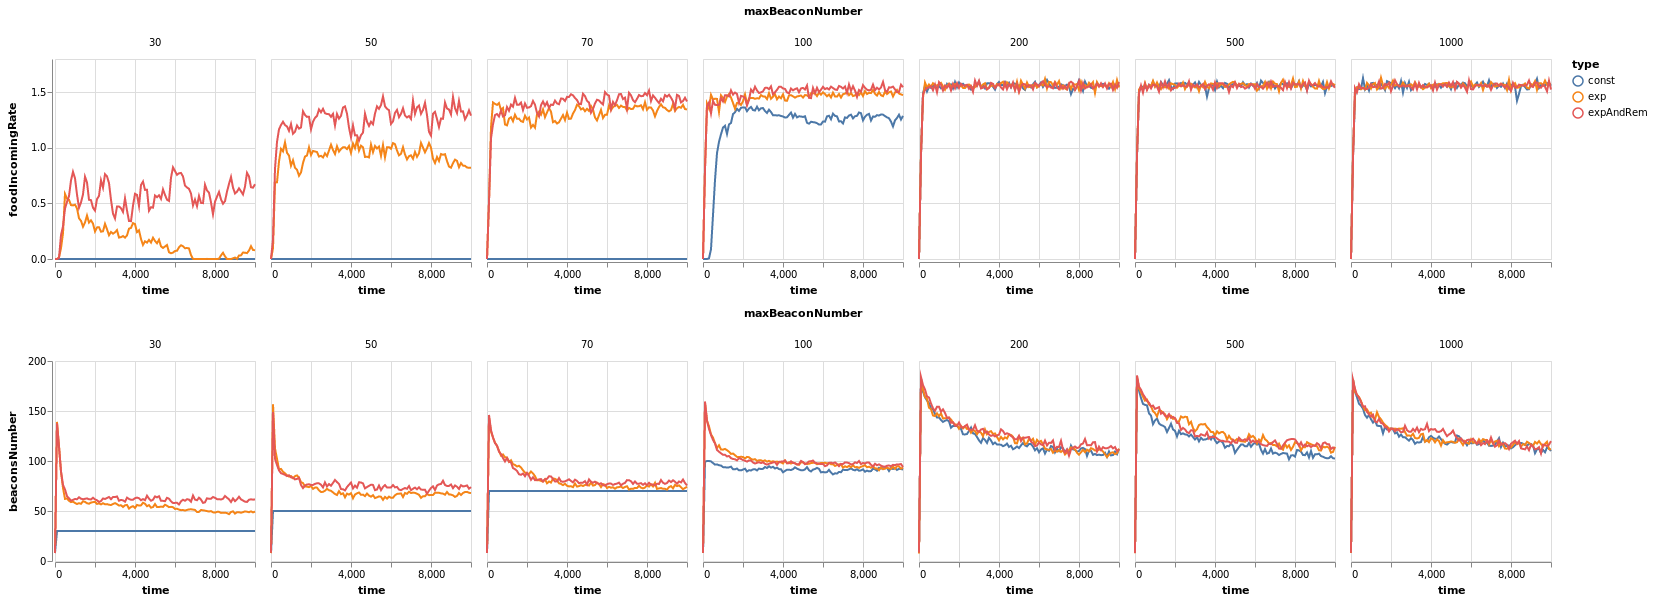

In [3]:
#here is displayed the performance of the models at all maxBeaconNumber's values

meanedDiff = diffMaxBeacons.groupby(['time','maxBeaconNumber','type']).mean().reset_index()
alt.Chart(meanedDiff).mark_line().properties(
    height=200,
    width =200).encode(
    x='time',
    y=alt.Y(alt.repeat("row"),type='quantitative'),
    color = 'type'
    ).facet(
    column='maxBeaconNumber').repeat( row=['foodIncomingRate','beaconsNumber'])

As predicted the “const” variation is not able to create a path between nest and food for values of maxBeaconNumber smaller than 100. The other variations, on the other hand, allow a huge spike in the number of beacons deployed at the beginning of the simulation and then an equilibrium between pDeploy and the removal of beacons is reached. The effectiveness of evading local maxima through their deletion shines at low maxBeaconNumber as is very unlikely that other ants create a bridge to escape from local maxima.

As maxBeaconNumber grows big enough, the performance of the models reaches the maximum. Once the path between food source and nest is established, the algorithm regulates the number of active beacons reaching an equilibrium that is the same for all models. The equilibrium value of the number of beacons can be influenced with maxBeaconNumber in “exp” and “expAndRem” if the parameter maxBeaconNumber is set low enough. This manipulation doesn’t really produce a sparser beacons’s network as its density is highly influenced by the move action that ants are able to perform. This reduction of mean beacons deployed is statistically linked to a drop in performance. This means that it’s not due to a shorter, less dense path.

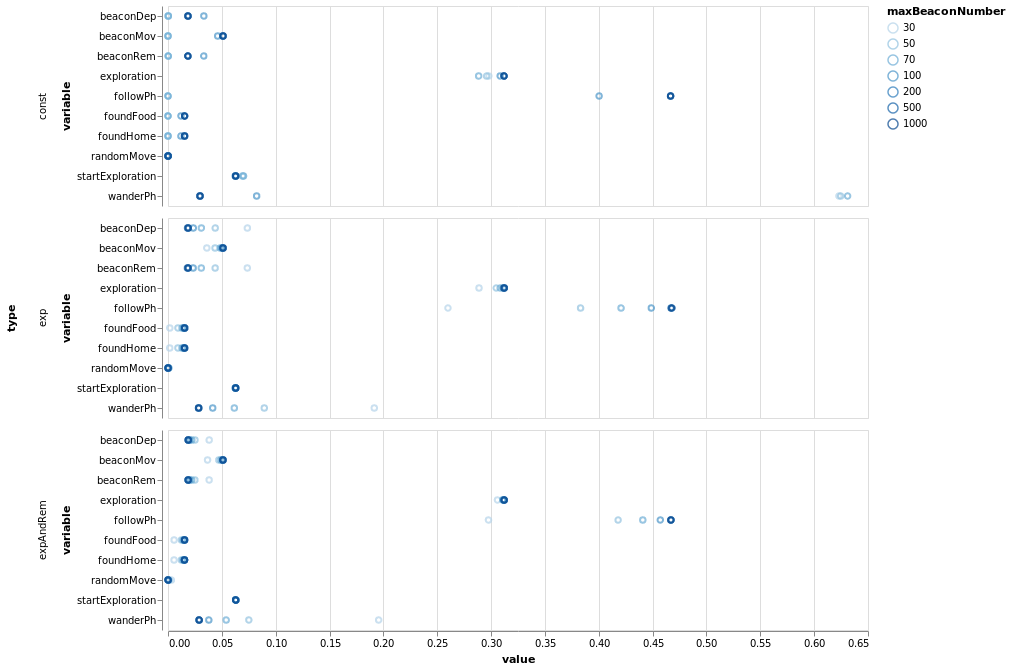

In [4]:
probabilities = alt.Chart(diffMaxBeacons.iloc[:,[0,-1]+list(range(6,16))].groupby(['maxBeaconNumber','type']).mean().reset_index().melt(['type','maxBeaconNumber']))

probabilities.mark_point().encode(
    x='value',
    y='variable',
    color = 'maxBeaconNumber:O').properties(
    width=700,
    height=200).facet(
    row='type')

#This plot shows how the mean distribution of ants actions over all ants and time varies with maxBeaconNumber's value.

# 4 Effect of beacon's finite lifetime on algorithm performances
## 4.1 Introduction of beacon's lifetime
Once the "expAndRem" is adopted as algorithm, beacons are modified to shorten their range in time with the law $ range(t) = k range(t-1)$ until range reaches the lower limit of half of the original range which is set to 10. After that, the beacon deactivates itself. The factor k is choosen to set the lifetime of the beacon at beaconTimescale. This changes the beacons's network as the ant now can only reach beacons whose range is bigger than their distance from the ant. This leads to a notion of neighborhood that isn't symmetric. If beacon A is reachable from beacon B, it's not guaranteed that beacon B is reachable from beacon A because they may have different ranges. This fact alters the way pheromones are updated as the last beacon visited might not be inside the neighborhood, thus preventing the ant from generating a trail of high levels of pheromone as expected.
To deal with this issue, the notion of neighborhood is forced to be symmetric, which means that the neighborhood of the current beacon where the ant is positioned is composed by beacons whose distance is less than the minimum range between their range and the current beacon’s one.

## 4.2 Simulations results

In [5]:
timescaleDF = pd.read_csv('data/beaconTimescale.csv.bz2')
meaned = timescaleDF.groupby(['beaconTimescale','time']).mean().reset_index().iloc[:,[0,1,3,4,5,6]]
timescaleDF.loc[:,['beaconTimescale','seed']].drop_duplicates().groupby('beaconTimescale').count()
# This few lines of code show how many simulations are taken into consideration to measure the performances of the model.

,seed
beaconTimescale,
0,60
1,60
4,60
8,60
16,60
32,60
64,60
128,60
256,60


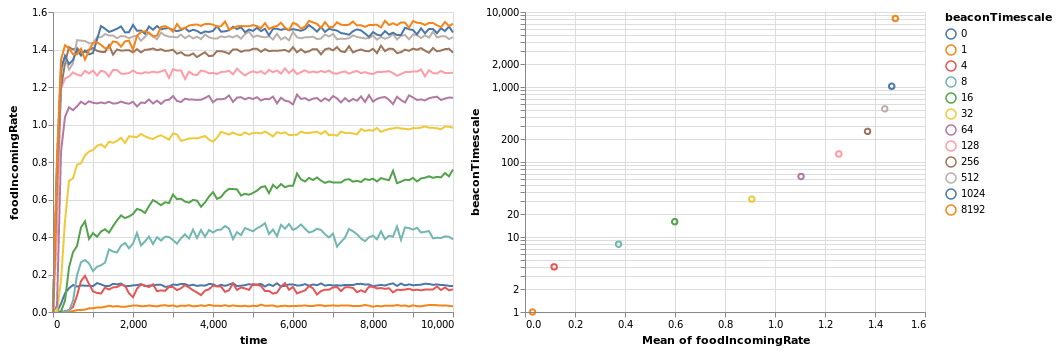

In [6]:
chart =alt.Chart(meaned)
gr1 =chart.mark_line().encode(
        x='time',
        y='foodIncomingRate',
        color='beaconTimescale:N')
gr2 = alt.Chart(meaned[meaned.beaconTimescale != 0]).mark_point().encode(
    x='mean(foodIncomingRate)',
    #x=alt.X('mean(foodIncomingRate)',scale=alt.Scale(type='log')),
    y=alt.Y('beaconTimescale',scale=alt.Scale(type='log')),
    color='beaconTimescale:N')
gr1 | gr2 

As reported in this graphs, peformances aren’t affected by beacon’s lifetime if it is much higher than the mean time that one ant needs to reach and bring back food to the nest (which is a sort of a temporal path length and will be referred as pathLength). Once this timescale reaches the same order of magnitude of the pathLength, performaces start to cap at a maximum equal to the level reached without a finite beacon’s lifetime. As reported in the graph on the right, the mean incoming food rate decreases almost exponentially between 4 and 64. After 64, performances grow sub-exponentially up to the peak of the previously discussed model.

With beaconTimeScale = 0 is reported the performance of ants moving at random unless there’s the nest or the food source in range. The extra complexity needed to deploy and maintain a beacon’s network pays off at timescales bigger than 4, which is an extreme case as the mean travelLength at peak performaces is around 90/100 timesteps. As more and more of the sub-optimal path can be maintained active, performances grow exponentially. At beaconTimescale = 16 the full path emerges as a macroscopic behaviour. From here to the highest scales the fraction of time dedicated to maintenance drops, favouring the behaviour of following the phermones trail as reported in the mean distribution of actions taken by the ants:

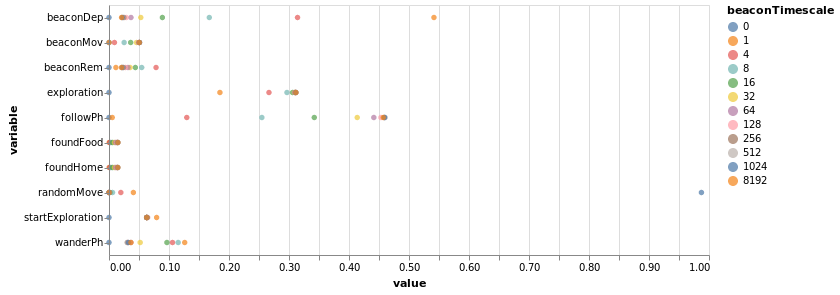

In [7]:
df1 = timescaleDF[['beaconTimescale','foundFood', 'foundHome', 'beaconRem', 'exploration', 'startExploration','beaconMov', 'followPh', 'beaconDep', 'wanderPh', 'randomMove']]
df2 = df1.groupby(['beaconTimescale']).mean().reset_index().melt(['beaconTimescale'])
df2 =df2[df2.beaconTimescale != 138]
alt.Chart(df2).mark_circle().encode(
    y = 'variable',
    #x = alt.X('value',scale=alt.Scale(type='log')),
    x='value',
    color = 'beaconTimescale:N').properties(
    height=250,
    width=600)


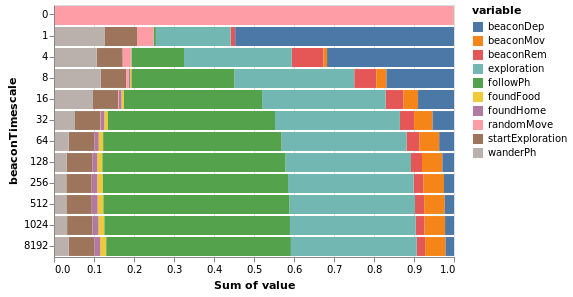

In [8]:
# This is an alternative view of the distribution of ant's actions. It's less readable if exact numbers are needed,
#but the visualization expresses better the shift in actions as the timescale rises.
alt.Chart(df2).mark_bar().encode(
    x=alt.X('sum(value)', stack="normalize"),
    y='beaconTimescale:N',
    color='variable'
)

In the last two following graphs are reported the average number of beacons deployed and the path length for every fixed timescale. The effect of a finite lifetime emerges in the number of beacons deployed as a rapid decrease around an interval as long as timescale from the beginning of the simulation. After this first period an equilibrium is reached. Very low timescales require a higher number of beacons as the path between nest and food source can't be maintained and the behaviour of the model is different. It is divided in 2 alternatig phases: in the first one, the majority of ants are looking for the food source and a path towards it is constructed. In the second phase, almost every ant gets to the food but the way home is interrupted and a new hunt for the nest begins. This leads to a constant exploration of the environment which is different from the first exploration as pheromone's values are different from 0, so beacons will be removed in the meantime. 

On the right the path length reflects the time needed for the path maintenance. The line with beaconsTimescale = 0 shows the mean time of first return to the nest that grows in time as the ants gets to spend more time wandering around the environment (this quantity has a power law distribution, so its mean isn't really meaningfull).

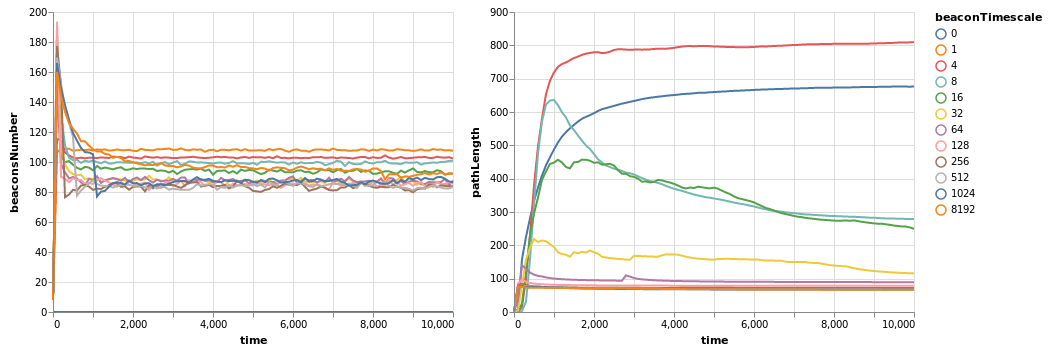

In [9]:
gr1 =chart.mark_line().encode(
        x='time',
        y='beaconsNumber',
        color='beaconTimescale:N')

gr2 = alt.Chart(meaned[meaned.beaconTimescale != 1]).mark_line().encode(
    x = 'time',
    y = 'pathLength',
    color= 'beaconTimescale:O'
    )
gr1 | gr2

# 5 Conclusions
As shown with the simulation’s results, the number of deployed beacons reaches an equilibrium between the rate of deployment and removal once the first ant reaches the food source. Limitations on this number as a hard limit damages the perfomances if set too low as this first exploration phase won’t be completed. The proposed pDeploy is able to lower the number of beacons deployed once the equilibrium has been reached at the cost of reducing also the performances. The proposed removal of local maxima is an effective way to deal with them in the condition of a low density system, where the probability of getting reached by the rest of the network is low.

When a finite beacon’s lifetime is considered, the algorithm is robust showing better performances than random moves even at extremely low timescales, and its performances aren’t affected significantly if this timescale exceedes the order of magnitude of the typical time needed to take the food and bring it back.

Future developments could explore the flexibility of the suboptimal path in a finite beacon’s lifetime where the food source isn’t fixed in a location. The heavy maintenance of the suboptimal path might increase its ability to follow the food source.